## K-Means

In [3]:
import csv
import random
import numpy as np
import matplotlib.pyplot as plt

from numpy.linalg import eig, norm, det
from scipy.linalg import inv

%matplotlib notebook

In [4]:
def ellipse(sigma, mean, scale=1):
    
    d, v = eig(inv(sigma))
    mat = v @ inv(np.sqrt(np.diag(d)))

    N = 200
    t = np.arange(0, N) * (2*np.pi) / N

    Y1 = scale * np.cos(t)
    Y2 = scale * np.sin(t)
   
    Y = np.array([Y1, Y2])

    X = mat.dot(Y)

    X1 = X[0]
    X2 = X[1]

    # move ellipse to mean_k
    X1 = X1 + mean[0]
    X2 = X2 + mean[1]
    
    return X1, X2

In [5]:
def plot(samples, parameters):

    sam_1 = samples["1"]
    sam_2 = samples["2"]
    sam_3 = samples["3"]

    data = (sam_1.T, sam_2.T, sam_3.T)
    colors = ("red", "green", "blue")
    groups = ("1", "2", "3")
    scales = (2, 2, 2)

    # Create plot
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    for data, color, group in zip(data, colors, groups):
        x, y = data
        ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

    for color, group, scale in zip(colors, groups, scales):
        X1, X2 = ellipse(parameters["sigma"][group], parameters["mean"][group], scale=scale)
        ax.plot(X1, X2, c=color)
    
    plt.title('K-Means - 1,2,3')
    plt.legend(loc=2)
    plt.show()

In [49]:
def get_random_means(train_a, train_o, train_u):

    points_a = [train_a[random.randrange(0, len(train_a))] for i in range(5)]
    points_o = [train_o[random.randrange(0, len(train_o))] for i in range(5)]
    points_u = [train_u[random.randrange(0, len(train_u))] for i in range(5)]

    return np.array([np.mean(points_a, axis=0), np.mean(points_o, axis=0), np.mean(points_u, axis=0)])

def get_zone_division_means(train_a, train_o, train_u):

    samples = np.array(list(train_a) + list(train_o) + list(train_u))
    
    mean = np.mean(samples, axis=0)
    
    samples_moved = np.array(list(map(lambda x: x - mean, samples)))
    phases = np.array(list(map(lambda x: np.mod(np.arctan2(x[1], x[0]), 2*np.pi), samples_moved)))
    
    samples_phases = list(zip(samples, phases))
    
    mean_phase_1 = list(filter(lambda x: x[1] > 0.0 and x[1] <= (2/3)*np.pi, samples_phases))
    mean_phase_2 = list(filter(lambda x: x[1] > (2/3)*np.pi and x[1] <= (4/3)*np.pi, samples_phases))
    mean_phase_3 = list(filter(lambda x: x[1] > (4/3)*np.pi and x[1] < 2*np.pi, samples_phases))
        
    mean_1 = list(map(lambda x: x[0], mean_phase_1))
    mean_2 = list(map(lambda x: x[0], mean_phase_2))
    mean_3 = list(map(lambda x: x[0], mean_phase_3))

    return np.array([np.mean(mean_1, axis=0), np.mean(mean_2, axis=0), np.mean(mean_3, axis=0)])

FMEANS = {
    "random": get_random_means,
    "zone-division": get_zone_division_means
}

def get_means(train_a, train_o, train_u, which):

    return FMEANS[which](train_a, train_o, train_u) 

In [7]:
def get_sigmas(clusters):
    
    return np.array([np.cov(c, rowvar=False) for c in clusters])

In [8]:
def get_clusters(samples, classes, K=3):
    
    return [np.array(list(map(lambda y: y[0], filter(lambda x: x[1] == k, zip(samples, classes)))))
                    for k in range(K)]

In [9]:
def calc_dist(samples, classes, means):
    
    dist = 0.0
    
    for i in range(len(samples)):
        d = norm(samples[i] - means[int(classes[i])])
        dist += d
    
    return dist

In [10]:
def k_means(samples, means):
    
    classes = np.zeros(len(samples))
    dist = np.zeros(2)
    
    dist[0] = 0.0
    dist[1] = 1E6
    
    while abs(dist[1] - dist[0]) > 0.01:
    
        # calculate distance from every point
        # to the centroids (a.k.a means) and find a class for
        # each point
        for i in range(len(samples)):
            norms = [(norm(samples[i] - means[k]), k) for k in range(3)]
            n, k = min(norms, key=lambda x: x[0])
            classes[i] = k

        # calculate the new values for the
        # centroids (a.k.a means)
        for k in range(3):
            points_with_class_k = list(map(lambda y: y[0], filter(lambda x: x[1] == k, zip(samples, classes))))
            mean_k = np.mean(points_with_class_k, axis=0)
            means[k] = mean_k
        
        # calculate distorsion
        dist[0] = dist[1]
        dist[1] = calc_dist(samples, classes, means)

    return means, classes

In [41]:
def parse():

    # parse data
    with open('a.txt') as f:
        lines_a = list(csv.reader(f, delimiter='\t'))

    with open('o.txt') as f:
        lines_o = list(csv.reader(f, delimiter='\t'))

    with open('u.txt') as f:
        lines_u = list(csv.reader(f, delimiter='\t'))

    lines_a = list(map(lambda x: [int(x[0]), int(x[1])],lines_a))
    lines_o = list(map(lambda x: [int(x[0]), int(x[1])],lines_o))
    lines_u = list(map(lambda x: [int(x[0]), int(x[1])],lines_u))

    # separate 'train' and 'test' datasets
    train_a = np.array(lines_a[:35])
    test_a = np.array(lines_a[35:])
    
    train_o = np.array(lines_o[:35])
    test_o = np.array(lines_o[35:])
    
    train_u = np.array(lines_u[:35])
    test_u = np.array(lines_u[35:])
    
    samples = np.array(list(train_a) + list(train_o) + list(train_u))
    
    data = {
        "train": {
            "1": train_a,
            "2": train_o,
            "3": train_u
        },
        "test": {
            "1": test_a,
            "2": test_o,
            "3": test_u
        }
    }
    
    return samples, data

In [43]:
samples, datasets = parse()

### K-means classification

In [14]:
def clasify(test, g1, g2, g3, which):

    positive = 0

    for sample in test:
        
        predictions = [(g1(sample), "1"), (g2(sample), "2"), (g3(sample), "3")]
        prob, k = max(predictions, key=lambda x: x[0])
        
        if k == which:
            positive += 1

    return positive

In [15]:
def g(x, mean, sigma, w):

    y = x - mean
    
    return np.log(w) - 0.5 * (np.log(det(sigma)) + y.T @ inv(sigma) @ y)

#### With means generated with five random points in each dataset

In [16]:
# obtain first means
# by calc the mean of 5 random
# points in samples
means = get_means(datasets["train"]["1"], datasets["train"]["2"], datasets["train"]["3"], "random")

means, classes = k_means(samples, means)

# separate samples in clusters considering
# the classes
clusters = get_clusters(samples, classes)

# calculate the sigmas for every class
sigmas = get_sigmas(clusters)

# plot the results
parameters_five_points = {
    "mean": {
        "1": means[0],
        "2": means[1],
        "3": means[2]
    },
    "sigma": {
        "1": sigmas[0],
        "2": sigmas[1],
        "3": sigmas[2]
    }
}

data_five_points = {
    "1": clusters[0],
    "2": clusters[1],
    "3": clusters[2]
}

In [17]:
x_tot = len(data_five_points["1"]) + len(data_five_points["2"]) + len(data_five_points["3"])

means = parameters_five_points["mean"]
sigmas = parameters_five_points["sigma"]

# calculate g functions
g1 = lambda x: g(x, means["1"], sigmas["1"], len(data_five_points["1"])/x_tot)
g2 = lambda x: g(x, means["2"], sigmas["2"], len(data_five_points["2"])/x_tot)
g3 = lambda x: g(x, means["3"], sigmas["3"], len(data_five_points["3"])/x_tot)

positive_1 = clasify(datasets["test"]["1"], g1, g2, g3, "1")
positive_2 = clasify(datasets["test"]["2"], g1, g2, g3, "2")
positive_3 = clasify(datasets["test"]["3"], g1, g2, g3, "3")

print("Test for class 1 - accuracy: {}".format(positive_1/len(datasets["test"]["1"])))
print("Test for class 2 - accuracy: {}".format(positive_2/len(datasets["test"]["2"])))
print("Test for class 3 - accuracy: {}".format(positive_3/len(datasets["test"]["3"])))

Test for class 1 - accuracy: 0.9333333333333333
Test for class 2 - accuracy: 1.0
Test for class 3 - accuracy: 0.9333333333333333


#### With means generated with XY-plane division in 3 zones

In [54]:
# obtain first means
# by dividing the XY-plane in three zones
# and finding the points in each zone, then
# calculate the means of those points
means = get_means(datasets["train"]["1"], datasets["train"]["2"], datasets["train"]["3"], "zone-division")

means, classes = k_means(samples, means)

# separate samples in clusters considering
# the classes
clusters = get_clusters(samples, classes)

# calculate the sigmas for every class
sigmas = get_sigmas(clusters)

# plot the results
parameters_zones = {
    "mean": {
        "1": means[0],
        "3": means[1],
        "2": means[2]
    },
    "sigma": {
        "1": sigmas[0],
        "3": sigmas[1],
        "2": sigmas[2]
    }
}

data_zones = {
    "1": clusters[0],
    "3": clusters[1],
    "2": clusters[2]
}

In [55]:
x_tot = len(data_zones["1"]) + len(data_zones["2"]) + len(data_zones["3"])

means = parameters_zones["mean"]
sigmas = parameters_zones["sigma"]

# calculate g functions
g1 = lambda x: g(x, means["1"], sigmas["1"], len(data_zones["1"])/x_tot)
g2 = lambda x: g(x, means["2"], sigmas["2"], len(data_zones["2"])/x_tot)
g3 = lambda x: g(x, means["3"], sigmas["3"], len(data_zones["3"])/x_tot)

positive_1 = clasify(datasets["test"]["1"], g1, g2, g3, "1")
positive_2 = clasify(datasets["test"]["2"], g1, g2, g3, "2")
positive_3 = clasify(datasets["test"]["3"], g1, g2, g3, "3")

print("Test for class 1 - accuracy: {}".format(positive_1/len(datasets["test"]["1"])))
print("Test for class 2 - accuracy: {}".format(positive_2/len(datasets["test"]["2"])))
print("Test for class 3 - accuracy: {}".format(positive_3/len(datasets["test"]["3"])))

Test for class 1 - accuracy: 0.9333333333333333
Test for class 2 - accuracy: 1.0
Test for class 3 - accuracy: 0.9333333333333333


### Plotting

<IPython.core.display.Javascript object>


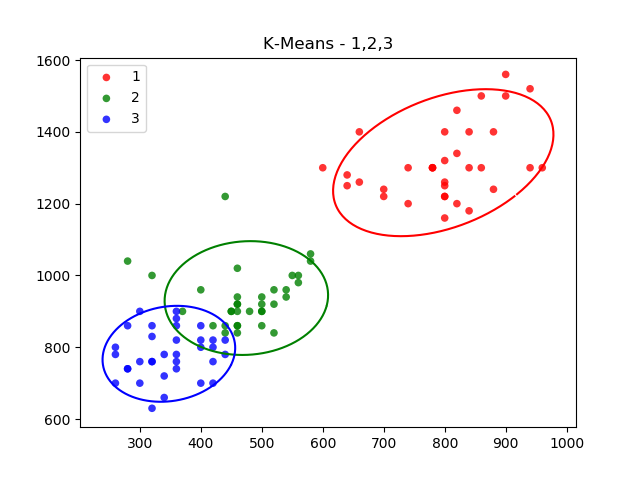

In [51]:
plot(data_five_points, parameters_five_points)

<IPython.core.display.Javascript object>


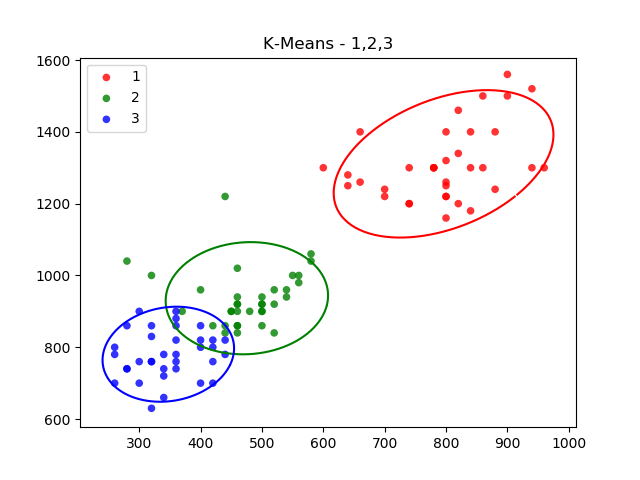

In [56]:
plot(data_zones, parameters_zones)